# Lesson 0038 - Botticelli Kandinsky Image Style Transfer
In this lesson, we want to find out how [Botticelli's Venus and Mars](https://de.wikipedia.org/wiki/Sandro_Botticelli#/media/Datei:Venus_and_Mars.jpg) would have looked like, if [Vassily Kandinsky](https://de.wikipedia.org/wiki/Wassily_Kandinsky#/media/Datei:Vassily_Kandinsky,_1923_-_Composition_8,_huile_sur_toile,_140_cm_x_201_cm,_Mus%C3%A9e_Guggenheim,_New_York.jpg) painted it.<br>
We can do this following the following idea: in a convolutional neural network, the first few layers contain very low level information like colors, basic shapes and so on. In the last few layers, this knowledge is aggregated to higher level information like the actual content. Therefore, we can define a loss function that on the one hand minimizes the distance of the activation of the manipulated image and the original Venus and Mars for very late layers, and on the other hand minimizes the distance between the activation of the manipulated image and Kandinsky's image in very early layers.<br>
We start by stealing code from [lesson 0037](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0037_yours_truly_deep_dream.ipynb).

In [1]:
import keras

print( keras.__version__ )

Using TensorFlow backend.


2.2.4


In [2]:
import numpy as np

print( np.__version__ )

1.16.2


In [3]:
from PIL import Image

print( Image.__version__ )

5.4.1


In [4]:
import requests

print( requests.__version__ )

2.21.0


In [5]:
from io import BytesIO

From now on, we call Venus and Mars the __content__ and Kandinsky the __style__.

In [6]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/Venus_and_Mars.jpg/1920px-Venus_and_Mars.jpg"

response = requests.get( url )

content = Image.open( BytesIO( response.content ) )

In [7]:
url = "https://upload.wikimedia.org/wikipedia/commons/4/47/Vassily_Kandinsky%2C_1923_-_Composition_8%2C_huile_sur_toile%2C_140_cm_x_201_cm%2C_Mus%C3%A9e_Guggenheim%2C_New_York.jpg"

response = requests.get( url )

style = Image.open( BytesIO( response.content ) )

We import [img_to_array](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/img_to_array) for mapping images to tensors.

In [8]:
from keras.preprocessing.image import img_to_array as ita

We will employ the [VGG19](https://keras.io/applications/#vgg19) net, and therefore, we will crop the images to maximal $224$ pixels in each dimension.

In [9]:
from keras.applications import vgg19

In [10]:
height, width = np.shape( content )[ 0 : 2 ]

width_content = 224

height_content = np.int32( height * 224 / width )

In [11]:
height, width = np.shape( style )[ 0 : 2 ]

width_style = 224

height_style = np.int32( height * 224 / width )

Next we create function for preprocessing the images.<br>
First, we resize the images using [resize](https://pillow.readthedocs.io/en/3.1.x/reference/Image.html), then we map the images to an array, then, since __VGG19__ expects a batch of images, we expand the dimension of the images, and finally, we employ [preprocess_input](https://keras.io/applications/).

In [12]:
def preprocess( img, width, height ):
    
    img = img.resize( ( width, height ), resample = Image.BILINEAR )
    
    img = ita( img )
    
    img = np.expand_dims( img, axis = 0 )
    
    img = vgg19.preprocess_input( img )
    
    return img

Next, we define __deprocess__ with which we will reverse the manipulations performed by __VGG19__ in __preprocess_input__. For this, we substract the minimal value from the image. Then, we divide the resulting image, whose minimal value is $0$ now, by its maximal value. Therefore, all the values in the image are between $0$ and $1$. Then we multiply this image by $255$ and change its value type to unsigned int with $8$ bits.

In [13]:
def deprocess( img ):
    
    img = img - np.min( img )
    
    img = ( img / np.max( img ) ) * 255
    
    img = img.astype( 'uint8' )
    
    return img

Now, we make a basic setup: we import the __backend__, and set the __style__ and the __content__ as [constant](https://www.tensorflow.org/api_docs/python/tf/keras/backend/constant). Then, we define a [placeholder](https://www.tensorflow.org/api_docs/python/tf/keras/backend/placeholder) for the style-transferred image. Then, we [concatenate](https://www.tensorflow.org/api_docs/python/tf/keras/backend/concatenate) these three images.<br>
During preprocessing, we employ the height and width of the __content__ for the __style__. This will change the proportions of the __style__, but we need this so that the dimensions fit.

In [14]:
import keras.backend as b

content_image = b.constant( preprocess( content, width_content, height_content ) )

style_image = b.constant( preprocess( style, width_content, height_content ) )

transferred = b.placeholder( ( 1, height_content, width_content, 3 ) )

input_tensor = b.concatenate( [ content_image, style_image, transferred ], axis = 0 )

Now, we load the model and set the __input_tensor__ as input.

In [15]:
model = vgg19.VGG19( input_tensor = input_tensor, weights = 'imagenet', include_top = False )

Instructions for updating:
Colocations handled automatically by placer.


Let's have a look at the architecture of __VGG19__:

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Now, we start defining the __loss function__. Remember: we want to minimize the difference in the activation in deeper layers for the __content__ and the __transferred__ image.

In [17]:
def loss_content( activation_content, activation_transferred ):
    
    return b.sum( b.square( activation_content - activation_transferred ) )

Next, we start defining functions for the __style loss__.<br>
We begin with the [Gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix). Given a set of vectors $v_{1}, v_{2}, \dots, v_{n}$, we define a matrix $A = \left( v_{1}, v_{2}, \dots, v_{n}\right)$. Using this, we define $G \left( A \right) = A^{ T } A$. Therefore $G \left( A \right) _{ i, j } = v_{ i }^{ T } v_{ j }$, and this measures how similar $v_{ i }$ and $v_{ j }$ are.<br>
Since our images are $4$-dimensional, we employ [batch_flatten](https://www.tensorflow.org/api_docs/python/tf/keras/backend/batch_flatten) to map the image to $2$-d. Then we use [dot](https://www.tensorflow.org/api_docs/python/tf/keras/backend/dot) to compute the product of the vectors, and [transpose](https://www.tensorflow.org/api_docs/python/tf/keras/backend/transpose) to compute the transpose of a vector.

In [18]:
def gram( x ):
    
    x = b.batch_flatten( x )
    
    gram = b.dot( x, b.transpose( x ) )
    
    return gram

For the __style loss__, we compute the __gram__ for the __style_image__ and the __transferred_image__, compute the square of the difference of these two matrices and sum over it. We then normalize this by the square of $3 * \text{height_content} * \text{width_content}$, because this is the number of entries in the __gram__.

In [19]:
def style_loss( style, transferred ):
    
    s = gram( style )
    
    t = gram( transferred )
    
    return b.sum( b.square( s - t ) ) / ( ( 3 * width_content * height_content ) ** 2 )

Since we do not want too much noise in the __transferred_image__, we define the __noise_loss__.<br>
For this, we compute two __derivatives__ as in [lesson 0030](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0030_bosch_feature_engineering_image_preprocessing.ipynb), one horizontal and one vertical. We then square the entries of the resulting matrices. Then, we add the matrices, and sum over it.

In [20]:
def noise_loss( transferred ):
    
    h = transferred[ :, : height_content - 1, : width_content - 1, : ] -\
    transferred[ :, 1:, : width_content - 1, : ]
    
    v = transferred[ :, : height_content - 1, : width_content - 1, : ] -\
    transferred[ :, : height_content - 1, 1:, : ]
    
    h = b.square( h )
    
    v = b.square( v )
    
    return b.sum( h + v )

Now, we create a dictionary of the output layers:

In [21]:
output = dict( [ ( layer.name, layer.output ) for layer in model.layers ] )

Next, we define the layers to be considered for the __content__:

In [22]:
content_layer = [ 'block5_conv1',
                'block5_conv2',
                'block5_conv3',
                'block5_conv4',
                'block4_conv1',
                'block4_conv2',
                'block4_conv3',
                'block4_conv4'
                ]

For the __style__, we will consider the first three layers:

In [23]:
style_layer = [ 'block1_conv1',
                'block1_conv2',
                'block2_conv1',
                'block2_conv2',
                'block3_conv1',
                'block3_conv2'
                ]

Now, we will give each of the __losses__ a weight, which is determined by what looks good.

In [24]:
weight_style = 100.0

weight_content = 100.0

weight_noise = 1.0

Now, we create the aggregated __loss__.<br>
We initialize the __loss__ to $0$.<br>
Then, we add the __loss_content__, where we consider the output of the __content_layer__ for the __content_image__ and __transferred__.<br>
Then, we do the same for the __style__, and finally, we add the __noise_loss__.

In [25]:
loss = b.variable( 0.0 )




for item in content_layer:
    
    features = output[ item ]
    
    content_features = features[ 0, :, :, : ]
    
    transferred_features = features[ 2, :, :, : ]
    
    loss = loss + weight_content * loss_content( content_features, transferred_features )
    
    
    
    
    
for item in style_layer:
    
    features = output[ item ]
    
    style_features = features[ 1, :, :, : ]
    
    transferred_features = features[ 2, :, :, : ]
    
    loss = loss + weight_style * style_loss( style_features, transferred_features )
    
    
    
    
loss = loss + weight_noise * noise_loss( transferred )

Next, we define the __gradient__, and also a function to return the __loss__ and the __gradient__ for a given __transferred__ image.

In [26]:
gradient = b.gradients( loss, transferred )[ 0 ]

fetch_loss_and_gradient = b.function( [ transferred ], [ loss, gradient ] )

Now, we minimize the __loss__ for $30$ iterations.

In [27]:
x = preprocess( content, width_content, height_content )

               
               
               
for i in range( 30 ):
    
    loss, gradient = fetch_loss_and_gradient( [ x ] )
    
    gradient = gradient / np.sum( np.abs( gradient ) ) * np.prod( np.shape( gradient ) )
    
    
    
    x = x - gradient
    
    
    
final = np.copy( x )

final = deprocess( final )

final = final[ 0, :, :, : ]

In [28]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


([], <a list of 0 Text yticklabel objects>)

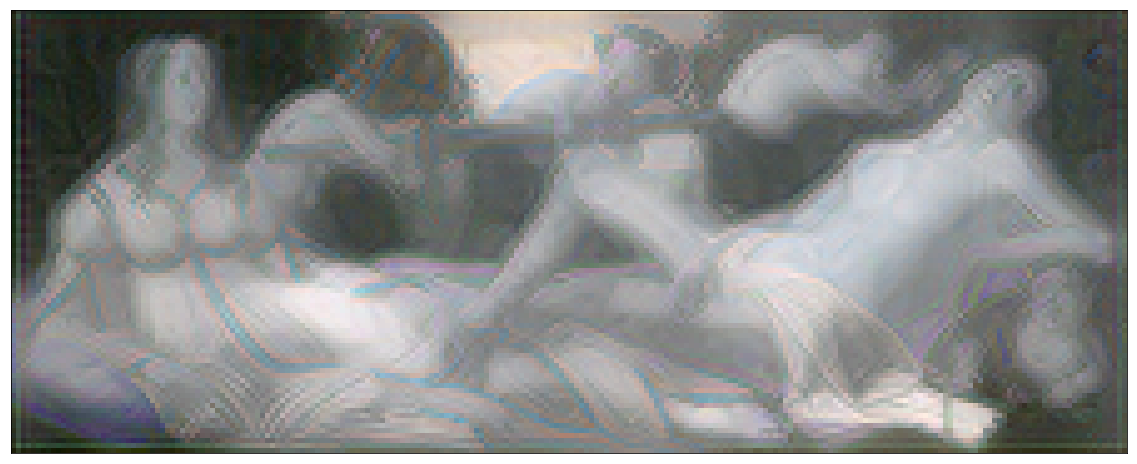

In [29]:
plt.figure( figsize = ( 20, 50 ) )

plt.imshow( final )

plt.xticks( [] )

plt.yticks( [] )

We notice, that we have lost pretty much content, but we also notice, that basic ideas of the content are preserved like basic geometric forms. We also notice the blue and orange bands, which might be a consequence of the style transfer.<br>
Class dismissed.